### 라이브러리 임포트

In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

### 데이터세트 로드

In [2]:
df=pd.read_excel('./modeling/optimal_data3_1/'+'Continous_2weeks_7day_1term.xlsx')
df.head()
X=df.iloc[:,[1,3,4,5,6,7]]
y=df.iloc[:,-1]

In [3]:
#아이디 갯수 325개, 리코드 176개
df.tail()

,0,1,2,3,4,5,6,7,8
57195,#ZZLSSL,68.0,29.048656,0.0,0.0,0.0,0.0,153.0,0
57196,#ZZLSSL,68.0,29.048656,0.0,0.0,0.0,0.0,153.0,0
57197,#ZZLSSL,68.0,29.048656,0.0,0.0,0.0,0.0,153.0,0
57198,#ZZLSSL,68.0,29.048656,0.0,0.0,0.0,0.0,153.0,0
57199,#ZZLSSL,68.0,29.048656,0.0,0.0,0.0,0.0,153.0,0


### 데이터 스케일링

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

smote = SMOTE(random_state=0)
X_train_over,y_train_over = smote.fit_resample(X_scaler,y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_scaler.shape, y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(y).value_counts())
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (57200, 6) (57200,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (150168, 6) (150168,)
SMOTE 적용 전 레이블 값 분포: 
 0    50056
1     4698
2     2446
Name: 8, dtype: int64
SMOTE 적용 후 레이블 값 분포: 
 0    50056
1    50056
2    50056
Name: 8, dtype: int64


### train, test dataset 나누기

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_train_over, y_train_over, test_size=0.20)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.to_numpy())
y_test = torch.LongTensor(y_test.to_numpy())

train_dataset=TensorDataset(X_train, y_train)
test_dataset=TensorDataset(X_test, y_test)

### 파라미터 값 정의

In [6]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
#total_dev_size = len(dev_dataset)

classes = 3
input_dim = 6

num_clients = 327
rounds = 30
batch_size = 128
epochs_per_client = 100
learning_rate = 2e-2

In [7]:
X

,1,3,4,5,6,7
0,45.15,72.0,0.0,0.0,0.0,148.0
1,45.15,72.0,0.0,0.0,0.0,148.0
2,45.15,72.0,0.0,0.0,0.0,148.0
3,45.15,72.0,0.0,0.0,0.0,148.0
4,45.15,72.0,0.0,0.0,0.0,148.0
...,...,...,...,...,...,...
57195,68.00,0.0,0.0,0.0,0.0,153.0
57196,68.00,0.0,0.0,0.0,0.0,153.0
57197,68.00,0.0,0.0,0.0,0.0,153.0
57198,68.00,0.0,0.0,0.0,0.0,153.0


### GPU 설정

In [8]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

### 딥러닝 모델 클래스 정의

In [9]:
class DNNModel(torch.nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.input_layer = nn.Linear(6, 128)
        self.hidden_layer1 = nn.Linear(128, 256)
        self.hidden_layer2 = nn.Linear(256, 128)
        self.output_layer   = nn.Linear(128,3)
        self.relu = nn.ReLU()
        self.track_layers = {'hidden_layer1': self.hidden_layer1, 'hidden_layer2': self.hidden_layer2, 'output_layer': self.output_layer}

    def forward(self, x):
        out =  self.relu(self.input_layer(x))
        out =  self.relu(self.hidden_layer1(out))
        out =  self.relu(self.hidden_layer2(out))
        out =  self.output_layer(out)
        return out 
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)       
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        print("evaluate_losses.,shape",np.array(losses).shape)
        print("evaluate_avg_loss",avg_loss)
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

### 클라이언트 클래스

In [10]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(DNNModel(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

### 클라이언트 셋업

In [11]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

### 중앙 서버 시작

In [12]:
global_net = to_device(DNNModel(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)
    
    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(test_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, ,train_acc={}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4),round(train_acc, 4) ,round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 1.0418, Accuracy = 0.4562
client_1: Loss = 1.0514, Accuracy = 0.4426
client_2: Loss = 1.0373, Accuracy = 0.4791
client_3: Loss = 1.0062, Accuracy = 0.5045
client_4: Loss = 1.0572, Accuracy = 0.4941
client_5: Loss = 1.0398, Accuracy = 0.457
client_6: Loss = 1.046, Accuracy = 0.4676
client_7: Loss = 1.0702, Accuracy = 0.4364
client_8: Loss = 1.0385, Accuracy = 0.4867
client_9: Loss = 1.0245, Accuracy = 0.4709
client_10: Loss = 1.063, Accuracy = 0.4793
client_11: Loss = 1.0505, Accuracy = 0.4811
client_12: Loss = 1.0396, Accuracy = 0.5001
client_13: Loss = 1.0247, Accuracy = 0.4608
client_14: Loss = 1.0253, Accuracy = 0.4713
client_15: Loss = 1.0266, Accuracy = 0.4699
client_16: Loss = 1.0628, Accuracy = 0.4264
client_17: Loss = 1.0211, Accuracy = 0.4739
client_18: Loss = 1.0465, Accuracy = 0.4548
client_19: Loss = 1.0504, Accuracy = 0.5097
client_20: Loss = 1.0567, Accuracy = 0.4695
client_21: Loss = 1.0128, Accuracy = 0.4751
client_22: Loss = 1.0308, A

client_185: Loss = 1.0239, Accuracy = 0.5075
client_186: Loss = 1.0112, Accuracy = 0.4773
client_187: Loss = 1.0569, Accuracy = 0.4679
client_188: Loss = 0.9817, Accuracy = 0.5227
client_189: Loss = 1.0541, Accuracy = 0.4695
client_190: Loss = 1.0356, Accuracy = 0.4825
client_191: Loss = 1.0487, Accuracy = 0.4585
client_192: Loss = 1.0436, Accuracy = 0.4372
client_193: Loss = 1.0465, Accuracy = 0.4699
client_194: Loss = 1.0252, Accuracy = 0.4969
client_195: Loss = 1.0609, Accuracy = 0.4859
client_196: Loss = 1.0494, Accuracy = 0.4546
client_197: Loss = 1.0612, Accuracy = 0.4627
client_198: Loss = 1.053, Accuracy = 0.4422
client_199: Loss = 1.0505, Accuracy = 0.4374
client_200: Loss = 1.027, Accuracy = 0.4827
client_201: Loss = 1.0509, Accuracy = 0.4619
client_202: Loss = 1.0443, Accuracy = 0.4611
client_203: Loss = 1.0391, Accuracy = 0.418
client_204: Loss = 1.0352, Accuracy = 0.4785
client_205: Loss = 1.0519, Accuracy = 0.4713
client_206: Loss = 1.0223, Accuracy = 0.4869
client_207: L

client_37: Loss = 1.016, Accuracy = 0.4717
client_38: Loss = 1.0386, Accuracy = 0.4452
client_39: Loss = 0.9972, Accuracy = 0.4917
client_40: Loss = 1.0261, Accuracy = 0.4779
client_41: Loss = 1.0314, Accuracy = 0.467
client_42: Loss = 0.9985, Accuracy = 0.4801
client_43: Loss = 1.0185, Accuracy = 0.4797
client_44: Loss = 1.037, Accuracy = 0.4811
client_45: Loss = 0.9917, Accuracy = 0.5061
client_46: Loss = 1.0018, Accuracy = 0.4923
client_47: Loss = 1.0432, Accuracy = 0.4769
client_48: Loss = 0.9894, Accuracy = 0.4905
client_49: Loss = 1.0388, Accuracy = 0.4624
client_50: Loss = 1.0196, Accuracy = 0.4917
client_51: Loss = 1.0215, Accuracy = 0.4532
client_52: Loss = 0.9977, Accuracy = 0.4729
client_53: Loss = 1.0307, Accuracy = 0.4735
client_54: Loss = 1.0421, Accuracy = 0.4969
client_55: Loss = 1.0174, Accuracy = 0.4911
client_56: Loss = 1.025, Accuracy = 0.4572
client_57: Loss = 1.0195, Accuracy = 0.4821
client_58: Loss = 1.038, Accuracy = 0.4546
client_59: Loss = 1.0468, Accuracy = 

client_222: Loss = 0.9992, Accuracy = 0.4783
client_223: Loss = 0.9541, Accuracy = 0.5434
client_224: Loss = 1.0281, Accuracy = 0.4859
client_225: Loss = 1.0243, Accuracy = 0.4901
client_226: Loss = 1.0374, Accuracy = 0.4641
client_227: Loss = 1.0314, Accuracy = 0.4645
client_228: Loss = 1.002, Accuracy = 0.5045
client_229: Loss = 1.022, Accuracy = 0.5099
client_230: Loss = 1.0067, Accuracy = 0.4967
client_231: Loss = 1.0166, Accuracy = 0.4883
client_232: Loss = 0.9826, Accuracy = 0.5163
client_233: Loss = 1.017, Accuracy = 0.4657
client_234: Loss = 1.0253, Accuracy = 0.4717
client_235: Loss = 1.0239, Accuracy = 0.4803
client_236: Loss = 1.0237, Accuracy = 0.463
client_237: Loss = 1.0419, Accuracy = 0.4376
client_238: Loss = 1.0073, Accuracy = 0.5205
client_239: Loss = 0.9899, Accuracy = 0.5317
client_240: Loss = 1.0269, Accuracy = 0.4627
client_241: Loss = 1.0205, Accuracy = 0.4616
client_242: Loss = 0.9685, Accuracy = 0.5153
client_243: Loss = 1.0124, Accuracy = 0.4717
client_244: Lo

client_75: Loss = 1.005, Accuracy = 0.4811
client_76: Loss = 0.9946, Accuracy = 0.5201
client_77: Loss = 0.9978, Accuracy = 0.4779
client_78: Loss = 0.9899, Accuracy = 0.5095
client_79: Loss = 1.0095, Accuracy = 0.4911
client_80: Loss = 1.0122, Accuracy = 0.4522
client_81: Loss = 1.0089, Accuracy = 0.4691
client_82: Loss = 1.0269, Accuracy = 0.4672
client_83: Loss = 1.0057, Accuracy = 0.4929
client_84: Loss = 0.977, Accuracy = 0.4895
client_85: Loss = 1.0236, Accuracy = 0.4829
client_86: Loss = 1.008, Accuracy = 0.4981
client_87: Loss = 1.0016, Accuracy = 0.4857
client_88: Loss = 0.9835, Accuracy = 0.5372
client_89: Loss = 1.0223, Accuracy = 0.4777
client_90: Loss = 1.0223, Accuracy = 0.4885
client_91: Loss = 1.0035, Accuracy = 0.4977
client_92: Loss = 0.9843, Accuracy = 0.5027
client_93: Loss = 1.0004, Accuracy = 0.4739
client_94: Loss = 0.9754, Accuracy = 0.5089
client_95: Loss = 0.9876, Accuracy = 0.4883
client_96: Loss = 1.0024, Accuracy = 0.5081
client_97: Loss = 1.0038, Accuracy 

client_259: Loss = 0.9855, Accuracy = 0.4783
client_260: Loss = 1.0155, Accuracy = 0.4657
client_261: Loss = 1.0205, Accuracy = 0.4857
client_262: Loss = 1.0093, Accuracy = 0.4771
client_263: Loss = 1.0338, Accuracy = 0.4699
client_264: Loss = 1.0068, Accuracy = 0.5241
client_265: Loss = 0.9988, Accuracy = 0.5141
client_266: Loss = 0.9909, Accuracy = 0.5119
client_267: Loss = 1.0108, Accuracy = 0.4494
client_268: Loss = 1.0171, Accuracy = 0.4813
client_269: Loss = 0.996, Accuracy = 0.5081
client_270: Loss = 1.0249, Accuracy = 0.4558
client_271: Loss = 0.9707, Accuracy = 0.4957
client_272: Loss = 1.0439, Accuracy = 0.436
client_273: Loss = 1.0187, Accuracy = 0.4865
client_274: Loss = 0.9972, Accuracy = 0.4877
client_275: Loss = 1.0363, Accuracy = 0.4729
client_276: Loss = 1.0313, Accuracy = 0.4578
client_277: Loss = 1.0228, Accuracy = 0.4729
client_278: Loss = 0.9933, Accuracy = 0.4619
client_279: Loss = 1.0269, Accuracy = 0.4753
client_280: Loss = 1.0294, Accuracy = 0.4791
client_281: 

client_112: Loss = 0.984, Accuracy = 0.4849
client_113: Loss = 1.0299, Accuracy = 0.4749
client_114: Loss = 0.9844, Accuracy = 0.5131
client_115: Loss = 0.9888, Accuracy = 0.5095
client_116: Loss = 1.0271, Accuracy = 0.4518
client_117: Loss = 1.0007, Accuracy = 0.4929
client_118: Loss = 1.0122, Accuracy = 0.4661
client_119: Loss = 0.9785, Accuracy = 0.5532
client_120: Loss = 1.022, Accuracy = 0.4514
client_121: Loss = 1.0269, Accuracy = 0.4534
client_122: Loss = 1.0188, Accuracy = 0.4672
client_123: Loss = 1.0382, Accuracy = 0.4725
client_124: Loss = 0.9798, Accuracy = 0.5133
client_125: Loss = 1.0005, Accuracy = 0.4789
client_126: Loss = 0.9789, Accuracy = 0.5317
client_127: Loss = 1.0015, Accuracy = 0.4999
client_128: Loss = 0.9697, Accuracy = 0.5339
client_129: Loss = 0.9739, Accuracy = 0.5067
client_130: Loss = 0.9942, Accuracy = 0.4997
client_131: Loss = 1.0129, Accuracy = 0.4739
client_132: Loss = 1.0145, Accuracy = 0.4861
client_133: Loss = 0.97, Accuracy = 0.5291
client_134: Lo

client_295: Loss = 0.9795, Accuracy = 0.5161
client_296: Loss = 0.9849, Accuracy = 0.5237
client_297: Loss = 0.9982, Accuracy = 0.5079
client_298: Loss = 1.0299, Accuracy = 0.4663
client_299: Loss = 0.9749, Accuracy = 0.5153
client_300: Loss = 1.0274, Accuracy = 0.4484
client_301: Loss = 0.9794, Accuracy = 0.5359
client_302: Loss = 1.0067, Accuracy = 0.4911
client_303: Loss = 1.0041, Accuracy = 0.5149
client_304: Loss = 0.9739, Accuracy = 0.5125
client_305: Loss = 0.9949, Accuracy = 0.4839
client_306: Loss = 1.0016, Accuracy = 0.5418
client_307: Loss = 0.9707, Accuracy = 0.4829
client_308: Loss = 1.0324, Accuracy = 0.4727
client_309: Loss = 1.0163, Accuracy = 0.4981
client_310: Loss = 0.9701, Accuracy = 0.5011
client_311: Loss = 0.9597, Accuracy = 0.5418
client_312: Loss = 1.012, Accuracy = 0.4697
client_313: Loss = 0.9664, Accuracy = 0.4997
client_314: Loss = 0.9895, Accuracy = 0.4821
client_315: Loss = 0.9693, Accuracy = 0.5373
client_316: Loss = 1.0198, Accuracy = 0.4889
client_317:

client_148: Loss = 0.9676, Accuracy = 0.5079
client_149: Loss = 0.9556, Accuracy = 0.5396
client_150: Loss = 0.9814, Accuracy = 0.5317
client_151: Loss = 0.9829, Accuracy = 0.4871
client_152: Loss = 1.0051, Accuracy = 0.4845
client_153: Loss = 0.9805, Accuracy = 0.5279
client_154: Loss = 0.9682, Accuracy = 0.5297
client_155: Loss = 0.976, Accuracy = 0.5141
client_156: Loss = 1.0018, Accuracy = 0.4989
client_157: Loss = 0.9648, Accuracy = 0.5376
client_158: Loss = 1.0047, Accuracy = 0.4941
client_159: Loss = 0.9909, Accuracy = 0.4917
client_160: Loss = 1.0089, Accuracy = 0.4969
client_161: Loss = 1.0041, Accuracy = 0.4895
client_162: Loss = 1.0131, Accuracy = 0.4771
client_163: Loss = 0.9809, Accuracy = 0.4971
client_164: Loss = 0.9849, Accuracy = 0.4877
client_165: Loss = 1.0094, Accuracy = 0.4849
client_166: Loss = 0.9845, Accuracy = 0.5193
client_167: Loss = 0.9703, Accuracy = 0.5235
client_168: Loss = 0.9493, Accuracy = 0.5037
client_169: Loss = 1.0134, Accuracy = 0.4905
client_170:

client_0: Loss = 0.9849, Accuracy = 0.5221
client_1: Loss = 0.9986, Accuracy = 0.4837
client_2: Loss = 0.9705, Accuracy = 0.4901
client_3: Loss = 0.9674, Accuracy = 0.5269
client_4: Loss = 0.988, Accuracy = 0.5211
client_5: Loss = 0.9916, Accuracy = 0.4811
client_6: Loss = 0.9911, Accuracy = 0.4929
client_7: Loss = 1.0176, Accuracy = 0.4993
client_8: Loss = 0.9762, Accuracy = 0.5017
client_9: Loss = 0.9782, Accuracy = 0.5137
client_10: Loss = 0.9893, Accuracy = 0.5011
client_11: Loss = 0.9759, Accuracy = 0.5073
client_12: Loss = 0.9612, Accuracy = 0.5081
client_13: Loss = 0.965, Accuracy = 0.4893
client_14: Loss = 0.9697, Accuracy = 0.5377
client_15: Loss = 0.9837, Accuracy = 0.5097
client_16: Loss = 1.0141, Accuracy = 0.4653
client_17: Loss = 0.9458, Accuracy = 0.5293
client_18: Loss = 0.9777, Accuracy = 0.4719
client_19: Loss = 0.9816, Accuracy = 0.5159
client_20: Loss = 1.0073, Accuracy = 0.4741
client_21: Loss = 0.9625, Accuracy = 0.4957
client_22: Loss = 0.9596, Accuracy = 0.5079


client_186: Loss = 0.9673, Accuracy = 0.5189
client_187: Loss = 0.9929, Accuracy = 0.4995
client_188: Loss = 0.922, Accuracy = 0.559
client_189: Loss = 1.0128, Accuracy = 0.4714
client_190: Loss = 0.9741, Accuracy = 0.5209
client_191: Loss = 0.9867, Accuracy = 0.5021
client_192: Loss = 0.9715, Accuracy = 0.5031
client_193: Loss = 0.9891, Accuracy = 0.5117
client_194: Loss = 0.9551, Accuracy = 0.5147
client_195: Loss = 1.0033, Accuracy = 0.4817
client_196: Loss = 0.9984, Accuracy = 0.4861
client_197: Loss = 1.0109, Accuracy = 0.4741
client_198: Loss = 1.0156, Accuracy = 0.4819
client_199: Loss = 0.9852, Accuracy = 0.4787
client_200: Loss = 0.9643, Accuracy = 0.5199
client_201: Loss = 1.0056, Accuracy = 0.4847
client_202: Loss = 0.989, Accuracy = 0.5059
client_203: Loss = 0.9862, Accuracy = 0.4973
client_204: Loss = 0.9686, Accuracy = 0.5265
client_205: Loss = 0.972, Accuracy = 0.5063
client_206: Loss = 0.9599, Accuracy = 0.5093
client_207: Loss = 0.9801, Accuracy = 0.5109
client_208: Lo

client_38: Loss = 0.9662, Accuracy = 0.5067
client_39: Loss = 0.9319, Accuracy = 0.5496
client_40: Loss = 0.9505, Accuracy = 0.4981
client_41: Loss = 0.9826, Accuracy = 0.4931
client_42: Loss = 0.9624, Accuracy = 0.5081
client_43: Loss = 0.979, Accuracy = 0.4991
client_44: Loss = 0.9891, Accuracy = 0.5213
client_45: Loss = 0.9492, Accuracy = 0.5173
client_46: Loss = 0.9544, Accuracy = 0.5255
client_47: Loss = 0.9905, Accuracy = 0.5071
client_48: Loss = 0.9496, Accuracy = 0.5329
client_49: Loss = 0.9869, Accuracy = 0.5436
client_50: Loss = 0.943, Accuracy = 0.5213
client_51: Loss = 0.9645, Accuracy = 0.4931
client_52: Loss = 0.9566, Accuracy = 0.5129
client_53: Loss = 0.9671, Accuracy = 0.5003
client_54: Loss = 0.9976, Accuracy = 0.5199
client_55: Loss = 0.9853, Accuracy = 0.5099
client_56: Loss = 0.9606, Accuracy = 0.5373
client_57: Loss = 0.9641, Accuracy = 0.5431
client_58: Loss = 0.9868, Accuracy = 0.4799
client_59: Loss = 0.9989, Accuracy = 0.4789
client_60: Loss = 0.9601, Accuracy

client_223: Loss = 0.8936, Accuracy = 0.5744
client_224: Loss = 0.9652, Accuracy = 0.5384
client_225: Loss = 0.9777, Accuracy = 0.5227
client_226: Loss = 0.9981, Accuracy = 0.4649
client_227: Loss = 0.9808, Accuracy = 0.5111
client_228: Loss = 0.9492, Accuracy = 0.5508
client_229: Loss = 0.9553, Accuracy = 0.5255
client_230: Loss = 0.9365, Accuracy = 0.5205
client_231: Loss = 0.9657, Accuracy = 0.5388
client_232: Loss = 0.9501, Accuracy = 0.5335
client_233: Loss = 0.9588, Accuracy = 0.5025
client_234: Loss = 0.9484, Accuracy = 0.5303
client_235: Loss = 0.9719, Accuracy = 0.5343
client_236: Loss = 0.9643, Accuracy = 0.5271
client_237: Loss = 0.9765, Accuracy = 0.4811
client_238: Loss = 0.9526, Accuracy = 0.5468
client_239: Loss = 0.9408, Accuracy = 0.5426
client_240: Loss = 0.9782, Accuracy = 0.5243
client_241: Loss = 0.9736, Accuracy = 0.4893
client_242: Loss = 0.8977, Accuracy = 0.559
client_243: Loss = 0.9399, Accuracy = 0.5131
client_244: Loss = 0.9761, Accuracy = 0.4877
client_245:

client_76: Loss = 0.9343, Accuracy = 0.5694
client_77: Loss = 0.9591, Accuracy = 0.5396
client_78: Loss = 0.9603, Accuracy = 0.5329
client_79: Loss = 0.9575, Accuracy = 0.5277
client_80: Loss = 0.9605, Accuracy = 0.4917
client_81: Loss = 0.981, Accuracy = 0.5287
client_82: Loss = 0.962, Accuracy = 0.5041
client_83: Loss = 0.9409, Accuracy = 0.5354
client_84: Loss = 0.9343, Accuracy = 0.5171
client_85: Loss = 0.9656, Accuracy = 0.5081
client_86: Loss = 0.9705, Accuracy = 0.5125
client_87: Loss = 0.9449, Accuracy = 0.5295
client_88: Loss = 0.945, Accuracy = 0.57
client_89: Loss = 0.9586, Accuracy = 0.5021
client_90: Loss = 0.9719, Accuracy = 0.545
client_91: Loss = 0.9588, Accuracy = 0.5021
client_92: Loss = 0.9521, Accuracy = 0.5065
client_93: Loss = 0.9595, Accuracy = 0.5279
client_94: Loss = 0.9488, Accuracy = 0.552
client_95: Loss = 0.9517, Accuracy = 0.5361
client_96: Loss = 0.9575, Accuracy = 0.555
client_97: Loss = 0.9587, Accuracy = 0.5085
client_98: Loss = 0.9511, Accuracy = 0.5

client_260: Loss = 0.9759, Accuracy = 0.4927
client_261: Loss = 0.966, Accuracy = 0.5141
client_262: Loss = 0.9559, Accuracy = 0.5353
client_263: Loss = 1.0057, Accuracy = 0.4957
client_264: Loss = 0.9719, Accuracy = 0.5067
client_265: Loss = 0.9501, Accuracy = 0.5574
client_266: Loss = 0.931, Accuracy = 0.5692
client_267: Loss = 0.973, Accuracy = 0.5157
client_268: Loss = 0.9824, Accuracy = 0.4851
client_269: Loss = 0.9559, Accuracy = 0.5187
client_270: Loss = 0.9695, Accuracy = 0.4981
client_271: Loss = 0.9371, Accuracy = 0.5456
client_272: Loss = 0.9886, Accuracy = 0.5111
client_273: Loss = 0.9599, Accuracy = 0.5127
client_274: Loss = 0.9648, Accuracy = 0.5089
client_275: Loss = 0.9626, Accuracy = 0.5075
client_276: Loss = 0.9894, Accuracy = 0.4883
client_277: Loss = 0.9565, Accuracy = 0.5065
client_278: Loss = 0.9527, Accuracy = 0.5085
client_279: Loss = 0.9863, Accuracy = 0.4825
client_280: Loss = 0.9628, Accuracy = 0.5355
client_281: Loss = 0.9414, Accuracy = 0.5628
client_282: L

client_113: Loss = 0.9501, Accuracy = 0.5366
client_114: Loss = 0.9395, Accuracy = 0.5542
client_115: Loss = 0.9219, Accuracy = 0.5704
client_116: Loss = 0.9701, Accuracy = 0.5127
client_117: Loss = 0.9485, Accuracy = 0.5149
client_118: Loss = 0.9818, Accuracy = 0.5145
client_119: Loss = 0.9263, Accuracy = 0.555
client_120: Loss = 0.9856, Accuracy = 0.4787
client_121: Loss = 1.002, Accuracy = 0.4819
client_122: Loss = 0.9863, Accuracy = 0.4947
client_123: Loss = 0.9867, Accuracy = 0.5077
client_124: Loss = 0.9475, Accuracy = 0.5335
client_125: Loss = 0.9579, Accuracy = 0.5213
client_126: Loss = 0.9232, Accuracy = 0.551
client_127: Loss = 0.9544, Accuracy = 0.5249
client_128: Loss = 0.9413, Accuracy = 0.5426
client_129: Loss = 0.9303, Accuracy = 0.5396
client_130: Loss = 0.9605, Accuracy = 0.5145
client_131: Loss = 0.9622, Accuracy = 0.5252
client_132: Loss = 0.9785, Accuracy = 0.5121
client_133: Loss = 0.9286, Accuracy = 0.5424
client_134: Loss = 0.9737, Accuracy = 0.5001
client_135: L

client_296: Loss = 0.9337, Accuracy = 0.5574
client_297: Loss = 0.9548, Accuracy = 0.5343
client_298: Loss = 1.0017, Accuracy = 0.4933
client_299: Loss = 0.9457, Accuracy = 0.5321
client_300: Loss = 0.9799, Accuracy = 0.5217
client_301: Loss = 0.9287, Accuracy = 0.558
client_302: Loss = 0.9561, Accuracy = 0.5592
client_303: Loss = 0.9677, Accuracy = 0.5444
client_304: Loss = 0.9381, Accuracy = 0.5215
client_305: Loss = 0.9583, Accuracy = 0.5103
client_306: Loss = 0.9685, Accuracy = 0.5452
client_307: Loss = 0.9223, Accuracy = 0.5512
client_308: Loss = 0.9847, Accuracy = 0.5029
client_309: Loss = 0.9627, Accuracy = 0.5236
client_310: Loss = 0.9226, Accuracy = 0.5432
client_311: Loss = 0.9233, Accuracy = 0.5786
client_312: Loss = 0.9657, Accuracy = 0.4997
client_313: Loss = 0.9266, Accuracy = 0.5335
client_314: Loss = 0.9461, Accuracy = 0.5492
client_315: Loss = 0.9249, Accuracy = 0.5269
client_316: Loss = 0.9631, Accuracy = 0.5377
client_317: Loss = 0.9524, Accuracy = 0.5335
client_318:

client_150: Loss = 0.936, Accuracy = 0.5402
client_151: Loss = 0.9433, Accuracy = 0.5199
client_152: Loss = 0.9747, Accuracy = 0.5029
client_153: Loss = 0.9362, Accuracy = 0.5534
client_154: Loss = 0.9228, Accuracy = 0.569
client_155: Loss = 0.9339, Accuracy = 0.5332
client_156: Loss = 0.9631, Accuracy = 0.5175
client_157: Loss = 0.9185, Accuracy = 0.5542
client_158: Loss = 0.9452, Accuracy = 0.5307
client_159: Loss = 0.9338, Accuracy = 0.5524
client_160: Loss = 0.9651, Accuracy = 0.5436
client_161: Loss = 0.9624, Accuracy = 0.5456
client_162: Loss = 0.9835, Accuracy = 0.4843
client_163: Loss = 0.9173, Accuracy = 0.5514
client_164: Loss = 0.949, Accuracy = 0.5057
client_165: Loss = 0.9796, Accuracy = 0.5255
client_166: Loss = 0.9414, Accuracy = 0.557
client_167: Loss = 0.9113, Accuracy = 0.564
client_168: Loss = 0.8983, Accuracy = 0.5534
client_169: Loss = 0.979, Accuracy = 0.5057
client_170: Loss = 0.9559, Accuracy = 0.5173
client_171: Loss = 0.9468, Accuracy = 0.4721
client_172: Loss

client_1: Loss = 0.9553, Accuracy = 0.5137
client_2: Loss = 0.9214, Accuracy = 0.5608
client_3: Loss = 0.9348, Accuracy = 0.543
client_4: Loss = 0.9488, Accuracy = 0.5335
client_5: Loss = 0.9478, Accuracy = 0.5329
client_6: Loss = 0.9403, Accuracy = 0.5197
client_7: Loss = 0.9812, Accuracy = 0.5005
client_8: Loss = 0.9438, Accuracy = 0.53
client_9: Loss = 0.9395, Accuracy = 0.5273
client_10: Loss = 0.9454, Accuracy = 0.5011
client_11: Loss = 0.9102, Accuracy = 0.5732
client_12: Loss = 0.9269, Accuracy = 0.5321
client_13: Loss = 0.9266, Accuracy = 0.5384
client_14: Loss = 0.9262, Accuracy = 0.5534
client_15: Loss = 0.9533, Accuracy = 0.5147
client_16: Loss = 0.9738, Accuracy = 0.5227
client_17: Loss = 0.8959, Accuracy = 0.5542
client_18: Loss = 0.9348, Accuracy = 0.5141
client_19: Loss = 0.9411, Accuracy = 0.5065
client_20: Loss = 0.9633, Accuracy = 0.5442
client_21: Loss = 0.9295, Accuracy = 0.5275
client_22: Loss = 0.9085, Accuracy = 0.5397
client_23: Loss = 0.9154, Accuracy = 0.5201


client_187: Loss = 0.9528, Accuracy = 0.5151
client_188: Loss = 0.8854, Accuracy = 0.5722
client_189: Loss = 0.9721, Accuracy = 0.5165
client_190: Loss = 0.9337, Accuracy = 0.5384
client_191: Loss = 0.9457, Accuracy = 0.5157
client_192: Loss = 0.9478, Accuracy = 0.5137
client_193: Loss = 0.9487, Accuracy = 0.5638
client_194: Loss = 0.9141, Accuracy = 0.5628
client_195: Loss = 0.9548, Accuracy = 0.5328
client_196: Loss = 0.9615, Accuracy = 0.5477
client_197: Loss = 0.972, Accuracy = 0.4993
client_198: Loss = 0.972, Accuracy = 0.5291
client_199: Loss = 0.9387, Accuracy = 0.5404
client_200: Loss = 0.9208, Accuracy = 0.5644
client_201: Loss = 0.9662, Accuracy = 0.5073
client_202: Loss = 0.9414, Accuracy = 0.5616
client_203: Loss = 0.9551, Accuracy = 0.563
client_204: Loss = 0.9407, Accuracy = 0.5648
client_205: Loss = 0.9288, Accuracy = 0.5199
client_206: Loss = 0.9248, Accuracy = 0.5454
client_207: Loss = 0.9492, Accuracy = 0.5209
client_208: Loss = 0.9712, Accuracy = 0.5376
client_209: L

client_39: Loss = 0.9106, Accuracy = 0.5778
client_40: Loss = 0.9182, Accuracy = 0.5638
client_41: Loss = 0.9515, Accuracy = 0.4993
client_42: Loss = 0.9257, Accuracy = 0.5414
client_43: Loss = 0.9404, Accuracy = 0.5213
client_44: Loss = 0.9627, Accuracy = 0.5446
client_45: Loss = 0.9265, Accuracy = 0.5237
client_46: Loss = 0.9161, Accuracy = 0.565
client_47: Loss = 0.9449, Accuracy = 0.5137
client_48: Loss = 0.9141, Accuracy = 0.5672
client_49: Loss = 0.9573, Accuracy = 0.5532
client_50: Loss = 0.9139, Accuracy = 0.5339
client_51: Loss = 0.9339, Accuracy = 0.5359
client_52: Loss = 0.9408, Accuracy = 0.5207
client_53: Loss = 0.9305, Accuracy = 0.5418
client_54: Loss = 0.9769, Accuracy = 0.5309
client_55: Loss = 0.9341, Accuracy = 0.5313
client_56: Loss = 0.9308, Accuracy = 0.5514
client_57: Loss = 0.9327, Accuracy = 0.566
client_58: Loss = 0.9398, Accuracy = 0.5097
client_59: Loss = 0.9566, Accuracy = 0.5668
client_60: Loss = 0.9255, Accuracy = 0.5397
client_61: Loss = 0.9248, Accuracy

client_224: Loss = 0.9221, Accuracy = 0.5518
client_225: Loss = 0.9472, Accuracy = 0.5474
client_226: Loss = 0.9541, Accuracy = 0.5275
client_227: Loss = 0.9407, Accuracy = 0.5123
client_228: Loss = 0.9013, Accuracy = 0.5692
client_229: Loss = 0.9213, Accuracy = 0.5183
client_230: Loss = 0.9022, Accuracy = 0.5744
client_231: Loss = 0.9265, Accuracy = 0.5283
client_232: Loss = 0.9254, Accuracy = 0.5432
client_233: Loss = 0.9332, Accuracy = 0.5446
client_234: Loss = 0.9182, Accuracy = 0.5345
client_235: Loss = 0.9439, Accuracy = 0.5328
client_236: Loss = 0.9113, Accuracy = 0.5438
client_237: Loss = 0.9309, Accuracy = 0.5406
client_238: Loss = 0.911, Accuracy = 0.5634
client_239: Loss = 0.9164, Accuracy = 0.5696
client_240: Loss = 0.9252, Accuracy = 0.5353
client_241: Loss = 0.9301, Accuracy = 0.5287
client_242: Loss = 0.861, Accuracy = 0.5996
client_243: Loss = 0.9185, Accuracy = 0.5351
client_244: Loss = 0.9392, Accuracy = 0.5524
client_245: Loss = 0.9205, Accuracy = 0.5502
client_246: 

client_77: Loss = 0.9181, Accuracy = 0.5628
client_78: Loss = 0.9186, Accuracy = 0.5756
client_79: Loss = 0.9366, Accuracy = 0.54
client_80: Loss = 0.9295, Accuracy = 0.5384
client_81: Loss = 0.9499, Accuracy = 0.5271
client_82: Loss = 0.9167, Accuracy = 0.5494
client_83: Loss = 0.8962, Accuracy = 0.5638
client_84: Loss = 0.9062, Accuracy = 0.5526
client_85: Loss = 0.913, Accuracy = 0.5305
client_86: Loss = 0.9369, Accuracy = 0.5377
client_87: Loss = 0.9104, Accuracy = 0.547
client_88: Loss = 0.9077, Accuracy = 0.5756
client_89: Loss = 0.9348, Accuracy = 0.5047
client_90: Loss = 0.942, Accuracy = 0.5329
client_91: Loss = 0.9363, Accuracy = 0.5744
client_92: Loss = 0.926, Accuracy = 0.5287
client_93: Loss = 0.9258, Accuracy = 0.5342
client_94: Loss = 0.9056, Accuracy = 0.5602
client_95: Loss = 0.9173, Accuracy = 0.5626
client_96: Loss = 0.9276, Accuracy = 0.556
client_97: Loss = 0.911, Accuracy = 0.5448
client_98: Loss = 0.918, Accuracy = 0.5664
client_99: Loss = 0.9355, Accuracy = 0.53

client_261: Loss = 0.937, Accuracy = 0.5373
client_262: Loss = 0.9329, Accuracy = 0.5412
client_263: Loss = 0.9745, Accuracy = 0.5073
client_264: Loss = 0.9438, Accuracy = 0.5263
client_265: Loss = 0.908, Accuracy = 0.5936
client_266: Loss = 0.888, Accuracy = 0.595
client_267: Loss = 0.9385, Accuracy = 0.57
client_268: Loss = 0.9559, Accuracy = 0.5295
client_269: Loss = 0.9206, Accuracy = 0.5668
client_270: Loss = 0.9352, Accuracy = 0.5456
client_271: Loss = 0.9026, Accuracy = 0.5702
client_272: Loss = 0.9429, Accuracy = 0.5518
client_273: Loss = 0.9403, Accuracy = 0.5337
client_274: Loss = 0.9382, Accuracy = 0.5039
client_275: Loss = 0.9315, Accuracy = 0.5408
client_276: Loss = 0.9665, Accuracy = 0.5041
client_277: Loss = 0.9166, Accuracy = 0.5137
client_278: Loss = 0.9184, Accuracy = 0.5524
client_279: Loss = 0.9532, Accuracy = 0.5249
client_280: Loss = 0.9324, Accuracy = 0.5305
client_281: Loss = 0.9007, Accuracy = 0.5902
client_282: Loss = 0.9283, Accuracy = 0.5532
client_283: Loss

client_115: Loss = 0.8942, Accuracy = 0.575
client_116: Loss = 0.9416, Accuracy = 0.5215
client_117: Loss = 0.9026, Accuracy = 0.5536
client_118: Loss = 0.9513, Accuracy = 0.5239
client_119: Loss = 0.8862, Accuracy = 0.5904
client_120: Loss = 0.9626, Accuracy = 0.5069
client_121: Loss = 0.9653, Accuracy = 0.5075
client_122: Loss = 0.9724, Accuracy = 0.5408
client_123: Loss = 0.9595, Accuracy = 0.5171
client_124: Loss = 0.921, Accuracy = 0.5484
client_125: Loss = 0.9269, Accuracy = 0.5257
client_126: Loss = 0.8926, Accuracy = 0.5486
client_127: Loss = 0.9267, Accuracy = 0.5502
client_128: Loss = 0.9128, Accuracy = 0.5358
client_129: Loss = 0.8846, Accuracy = 0.5736
client_130: Loss = 0.9277, Accuracy = 0.5694
client_131: Loss = 0.9239, Accuracy = 0.5466
client_132: Loss = 0.9354, Accuracy = 0.5464
client_133: Loss = 0.9019, Accuracy = 0.548
client_134: Loss = 0.948, Accuracy = 0.5656
client_135: Loss = 0.9411, Accuracy = 0.5123
client_136: Loss = 0.9418, Accuracy = 0.5476
client_137: Lo

client_298: Loss = 0.9737, Accuracy = 0.5035
client_299: Loss = 0.9185, Accuracy = 0.5343
client_300: Loss = 0.9522, Accuracy = 0.5536
client_301: Loss = 0.9064, Accuracy = 0.5812
client_302: Loss = 0.9368, Accuracy = 0.5754
client_303: Loss = 0.9248, Accuracy = 0.588
client_304: Loss = 0.9032, Accuracy = 0.5746
client_305: Loss = 0.9227, Accuracy = 0.5321
client_306: Loss = 0.9305, Accuracy = 0.5852
client_307: Loss = 0.9015, Accuracy = 0.5764
client_308: Loss = 0.9506, Accuracy = 0.5442
client_309: Loss = 0.9269, Accuracy = 0.5428
client_310: Loss = 0.8974, Accuracy = 0.5614
client_311: Loss = 0.8866, Accuracy = 0.6128
client_312: Loss = 0.9459, Accuracy = 0.5244
client_313: Loss = 0.896, Accuracy = 0.567
client_314: Loss = 0.9247, Accuracy = 0.5309
client_315: Loss = 0.8836, Accuracy = 0.579
client_316: Loss = 0.9212, Accuracy = 0.567
client_317: Loss = 0.9112, Accuracy = 0.5746
client_318: Loss = 0.8973, Accuracy = 0.5712
client_319: Loss = 0.9581, Accuracy = 0.5247
client_320: Los

client_152: Loss = 0.9509, Accuracy = 0.5584
client_153: Loss = 0.9127, Accuracy = 0.5552
client_154: Loss = 0.8942, Accuracy = 0.5822
client_155: Loss = 0.9137, Accuracy = 0.5393
client_156: Loss = 0.93, Accuracy = 0.5291
client_157: Loss = 0.879, Accuracy = 0.5714
client_158: Loss = 0.9168, Accuracy = 0.545
client_159: Loss = 0.8858, Accuracy = 0.5804
client_160: Loss = 0.9416, Accuracy = 0.5686
client_161: Loss = 0.9258, Accuracy = 0.5952
client_162: Loss = 0.953, Accuracy = 0.5107
client_163: Loss = 0.8804, Accuracy = 0.5948
client_164: Loss = 0.9179, Accuracy = 0.552
client_165: Loss = 0.9773, Accuracy = 0.5077
client_166: Loss = 0.9249, Accuracy = 0.5566
client_167: Loss = 0.8752, Accuracy = 0.5658
client_168: Loss = 0.8671, Accuracy = 0.596
client_169: Loss = 0.9555, Accuracy = 0.5167
client_170: Loss = 0.9344, Accuracy = 0.5223
client_171: Loss = 0.9206, Accuracy = 0.5309
client_172: Loss = 0.9051, Accuracy = 0.5672
client_173: Loss = 0.9113, Accuracy = 0.5462
client_174: Loss 

client_3: Loss = 0.906, Accuracy = 0.5764
client_4: Loss = 0.9304, Accuracy = 0.547
client_5: Loss = 0.9293, Accuracy = 0.5397
client_6: Loss = 0.9203, Accuracy = 0.5392
client_7: Loss = 0.9522, Accuracy = 0.5221
client_8: Loss = 0.9252, Accuracy = 0.5313
client_9: Loss = 0.9095, Accuracy = 0.5466
client_10: Loss = 0.9089, Accuracy = 0.553
client_11: Loss = 0.8789, Accuracy = 0.5676
client_12: Loss = 0.9018, Accuracy = 0.56
client_13: Loss = 0.8989, Accuracy = 0.5888
client_14: Loss = 0.8958, Accuracy = 0.6026
client_15: Loss = 0.9232, Accuracy = 0.5518
client_16: Loss = 0.9462, Accuracy = 0.5277
client_17: Loss = 0.8637, Accuracy = 0.5806
client_18: Loss = 0.8971, Accuracy = 0.5265
client_19: Loss = 0.9124, Accuracy = 0.5514
client_20: Loss = 0.9302, Accuracy = 0.5518
client_21: Loss = 0.9084, Accuracy = 0.5367
client_22: Loss = 0.8981, Accuracy = 0.5546
client_23: Loss = 0.8803, Accuracy = 0.5423
client_24: Loss = 0.895, Accuracy = 0.5317
client_25: Loss = 0.8723, Accuracy = 0.5868
c

client_189: Loss = 0.9487, Accuracy = 0.5187
client_190: Loss = 0.9022, Accuracy = 0.5754
client_191: Loss = 0.9307, Accuracy = 0.5299
client_192: Loss = 0.9096, Accuracy = 0.5514
client_193: Loss = 0.9251, Accuracy = 0.5572
client_194: Loss = 0.892, Accuracy = 0.55
client_195: Loss = 0.9297, Accuracy = 0.5556
client_196: Loss = 0.9212, Accuracy = 0.5684
client_197: Loss = 0.9495, Accuracy = 0.4715
client_198: Loss = 0.9503, Accuracy = 0.5167
client_199: Loss = 0.9101, Accuracy = 0.5299
client_200: Loss = 0.8989, Accuracy = 0.5694
client_201: Loss = 0.9465, Accuracy = 0.5097
client_202: Loss = 0.9164, Accuracy = 0.561
client_203: Loss = 0.915, Accuracy = 0.5798
client_204: Loss = 0.9048, Accuracy = 0.5454
client_205: Loss = 0.9004, Accuracy = 0.5606
client_206: Loss = 0.8873, Accuracy = 0.6079
client_207: Loss = 0.9294, Accuracy = 0.5484
client_208: Loss = 0.9261, Accuracy = 0.5592
client_209: Loss = 0.9492, Accuracy = 0.4963
client_210: Loss = 0.9069, Accuracy = 0.5638
client_211: Los

client_41: Loss = 0.9213, Accuracy = 0.5412
client_42: Loss = 0.8975, Accuracy = 0.5744
client_43: Loss = 0.9228, Accuracy = 0.552
client_44: Loss = 0.9389, Accuracy = 0.5554
client_45: Loss = 0.8804, Accuracy = 0.5894
client_46: Loss = 0.8907, Accuracy = 0.5794
client_47: Loss = 0.9156, Accuracy = 0.5736
client_48: Loss = 0.8817, Accuracy = 0.578
client_49: Loss = 0.9247, Accuracy = 0.5872
client_50: Loss = 0.8779, Accuracy = 0.5822
client_51: Loss = 0.8991, Accuracy = 0.553
client_52: Loss = 0.9318, Accuracy = 0.544
client_53: Loss = 0.8974, Accuracy = 0.5608
client_54: Loss = 0.9516, Accuracy = 0.5522
client_55: Loss = 0.9149, Accuracy = 0.5235
client_56: Loss = 0.9075, Accuracy = 0.5588
client_57: Loss = 0.8973, Accuracy = 0.5708
client_58: Loss = 0.9068, Accuracy = 0.5582
client_59: Loss = 0.9242, Accuracy = 0.5886
client_60: Loss = 0.8808, Accuracy = 0.5552
client_61: Loss = 0.8895, Accuracy = 0.5726
client_62: Loss = 0.9185, Accuracy = 0.5842
client_63: Loss = 0.9399, Accuracy =

client_226: Loss = 0.9175, Accuracy = 0.5572
client_227: Loss = 0.9205, Accuracy = 0.5199
client_228: Loss = 0.8737, Accuracy = 0.5884
client_229: Loss = 0.8919, Accuracy = 0.5456
client_230: Loss = 0.8691, Accuracy = 0.5502
client_231: Loss = 0.9088, Accuracy = 0.5316
client_232: Loss = 0.8967, Accuracy = 0.5534
client_233: Loss = 0.8957, Accuracy = 0.5632
client_234: Loss = 0.8861, Accuracy = 0.5672
client_235: Loss = 0.9124, Accuracy = 0.5502
client_236: Loss = 0.8806, Accuracy = 0.572
client_237: Loss = 0.8969, Accuracy = 0.5526
client_238: Loss = 0.8853, Accuracy = 0.5816
client_239: Loss = 0.889, Accuracy = 0.576
client_240: Loss = 0.9069, Accuracy = 0.5574
client_241: Loss = 0.9126, Accuracy = 0.5628
client_242: Loss = 0.8347, Accuracy = 0.6017
client_243: Loss = 0.8953, Accuracy = 0.5552
client_244: Loss = 0.8971, Accuracy = 0.567
client_245: Loss = 0.8866, Accuracy = 0.5768
client_246: Loss = 0.9308, Accuracy = 0.5335
client_247: Loss = 0.9093, Accuracy = 0.5702
client_248: Lo

client_79: Loss = 0.9378, Accuracy = 0.5041
client_80: Loss = 0.9036, Accuracy = 0.5554
client_81: Loss = 0.9248, Accuracy = 0.5291
client_82: Loss = 0.9016, Accuracy = 0.5516
client_83: Loss = 0.8691, Accuracy = 0.5756
client_84: Loss = 0.8728, Accuracy = 0.5522
client_85: Loss = 0.8856, Accuracy = 0.589
client_86: Loss = 0.9197, Accuracy = 0.5506
client_87: Loss = 0.8831, Accuracy = 0.5634
client_88: Loss = 0.8749, Accuracy = 0.575
client_89: Loss = 0.8945, Accuracy = 0.5175
client_90: Loss = 0.9179, Accuracy = 0.581
client_91: Loss = 0.906, Accuracy = 0.5652
client_92: Loss = 0.9047, Accuracy = 0.5385
client_93: Loss = 0.8911, Accuracy = 0.5646
client_94: Loss = 0.8807, Accuracy = 0.5836
client_95: Loss = 0.8949, Accuracy = 0.5652
client_96: Loss = 0.8926, Accuracy = 0.5796
client_97: Loss = 0.8784, Accuracy = 0.5768
client_98: Loss = 0.8949, Accuracy = 0.5808
client_99: Loss = 0.912, Accuracy = 0.56
client_100: Loss = 0.9206, Accuracy = 0.5546
client_101: Loss = 0.905, Accuracy = 0

client_263: Loss = 0.9303, Accuracy = 0.5626
client_264: Loss = 0.9004, Accuracy = 0.5776
client_265: Loss = 0.877, Accuracy = 0.6093
client_266: Loss = 0.8656, Accuracy = 0.594
client_267: Loss = 0.9103, Accuracy = 0.572
client_268: Loss = 0.948, Accuracy = 0.5332
client_269: Loss = 0.8913, Accuracy = 0.5906
client_270: Loss = 0.9007, Accuracy = 0.5622
client_271: Loss = 0.8741, Accuracy = 0.5974
client_272: Loss = 0.9356, Accuracy = 0.5297
client_273: Loss = 0.9307, Accuracy = 0.5472
client_274: Loss = 0.9195, Accuracy = 0.5482
client_275: Loss = 0.9225, Accuracy = 0.5366
client_276: Loss = 0.9501, Accuracy = 0.5193
client_277: Loss = 0.8724, Accuracy = 0.5548
client_278: Loss = 0.8777, Accuracy = 0.5888
client_279: Loss = 0.9309, Accuracy = 0.5438
client_280: Loss = 0.9141, Accuracy = 0.5458
client_281: Loss = 0.877, Accuracy = 0.5988
client_282: Loss = 0.8964, Accuracy = 0.566
client_283: Loss = 0.9026, Accuracy = 0.5726
client_284: Loss = 0.9153, Accuracy = 0.5568
client_285: Loss

client_117: Loss = 0.8845, Accuracy = 0.5444
client_118: Loss = 0.9348, Accuracy = 0.5377
client_119: Loss = 0.8539, Accuracy = 0.6111
client_120: Loss = 0.9419, Accuracy = 0.5301
client_121: Loss = 0.9289, Accuracy = 0.5548
client_122: Loss = 0.9409, Accuracy = 0.5506
client_123: Loss = 0.9089, Accuracy = 0.543
client_124: Loss = 0.8957, Accuracy = 0.5512
client_125: Loss = 0.8984, Accuracy = 0.5654
client_126: Loss = 0.8764, Accuracy = 0.5906
client_127: Loss = 0.9028, Accuracy = 0.5558
client_128: Loss = 0.8827, Accuracy = 0.5746
client_129: Loss = 0.8612, Accuracy = 0.5852
client_130: Loss = 0.896, Accuracy = 0.582
client_131: Loss = 0.8936, Accuracy = 0.5802
client_132: Loss = 0.9264, Accuracy = 0.5526
client_133: Loss = 0.8745, Accuracy = 0.575
client_134: Loss = 0.9172, Accuracy = 0.572
client_135: Loss = 0.9199, Accuracy = 0.5568
client_136: Loss = 0.9079, Accuracy = 0.5614
client_137: Loss = 0.9113, Accuracy = 0.5708
client_138: Loss = 0.8963, Accuracy = 0.5662
client_139: Los

client_301: Loss = 0.8845, Accuracy = 0.5808
client_302: Loss = 0.9225, Accuracy = 0.5812
client_303: Loss = 0.8958, Accuracy = 0.6209
client_304: Loss = 0.8748, Accuracy = 0.5836
client_305: Loss = 0.8983, Accuracy = 0.5522
client_306: Loss = 0.9054, Accuracy = 0.6018
client_307: Loss = 0.8766, Accuracy = 0.6004
client_308: Loss = 0.9253, Accuracy = 0.559
client_309: Loss = 0.911, Accuracy = 0.547
client_310: Loss = 0.8801, Accuracy = 0.588
client_311: Loss = 0.8558, Accuracy = 0.5954
client_312: Loss = 0.9209, Accuracy = 0.5574
client_313: Loss = 0.8654, Accuracy = 0.6016
client_314: Loss = 0.8849, Accuracy = 0.5846
client_315: Loss = 0.8415, Accuracy = 0.5884
client_316: Loss = 0.9002, Accuracy = 0.565
client_317: Loss = 0.9116, Accuracy = 0.5742
client_318: Loss = 0.8865, Accuracy = 0.5668
client_319: Loss = 0.9337, Accuracy = 0.5392
client_320: Loss = 0.8882, Accuracy = 0.5852
client_321: Loss = 0.8815, Accuracy = 0.5774
client_322: Loss = 0.9024, Accuracy = 0.5652
client_323: Los

client_155: Loss = 0.8733, Accuracy = 0.6079
client_156: Loss = 0.8838, Accuracy = 0.5694
client_157: Loss = 0.8746, Accuracy = 0.6067
client_158: Loss = 0.8891, Accuracy = 0.5806
client_159: Loss = 0.876, Accuracy = 0.608
client_160: Loss = 0.9151, Accuracy = 0.5568
client_161: Loss = 0.8914, Accuracy = 0.6259
client_162: Loss = 0.9162, Accuracy = 0.5726
client_163: Loss = 0.8668, Accuracy = 0.6087
client_164: Loss = 0.8995, Accuracy = 0.5704
client_165: Loss = 0.9213, Accuracy = 0.5317
client_166: Loss = 0.887, Accuracy = 0.5746
client_167: Loss = 0.858, Accuracy = 0.5842
client_168: Loss = 0.8277, Accuracy = 0.6173
client_169: Loss = 0.9279, Accuracy = 0.5408
client_170: Loss = 0.9043, Accuracy = 0.5586
client_171: Loss = 0.8818, Accuracy = 0.5782
client_172: Loss = 0.8809, Accuracy = 0.5644
client_173: Loss = 0.888, Accuracy = 0.5762
client_174: Loss = 0.8947, Accuracy = 0.5678
client_175: Loss = 0.9451, Accuracy = 0.5159
client_176: Loss = 0.8785, Accuracy = 0.5996
client_177: Los

client_7: Loss = 0.9289, Accuracy = 0.5328
client_8: Loss = 0.8971, Accuracy = 0.5554
client_9: Loss = 0.8776, Accuracy = 0.5576
client_10: Loss = 0.912, Accuracy = 0.5464
client_11: Loss = 0.856, Accuracy = 0.5772
client_12: Loss = 0.9005, Accuracy = 0.5552
client_13: Loss = 0.8697, Accuracy = 0.588
client_14: Loss = 0.8718, Accuracy = 0.5554
client_15: Loss = 0.8979, Accuracy = 0.5732
client_16: Loss = 0.8959, Accuracy = 0.5828
client_17: Loss = 0.8425, Accuracy = 0.6219
client_18: Loss = 0.8797, Accuracy = 0.546
client_19: Loss = 0.8905, Accuracy = 0.5858
client_20: Loss = 0.8995, Accuracy = 0.5574
client_21: Loss = 0.8876, Accuracy = 0.549
client_22: Loss = 0.8718, Accuracy = 0.5754
client_23: Loss = 0.8519, Accuracy = 0.582
client_24: Loss = 0.8695, Accuracy = 0.576
client_25: Loss = 0.8563, Accuracy = 0.577
client_26: Loss = 0.8653, Accuracy = 0.568
client_27: Loss = 0.8569, Accuracy = 0.577
client_28: Loss = 0.905, Accuracy = 0.5754
client_29: Loss = 0.9061, Accuracy = 0.5574
cl

client_193: Loss = 0.8964, Accuracy = 0.5814
client_194: Loss = 0.8499, Accuracy = 0.6068
client_195: Loss = 0.908, Accuracy = 0.566
client_196: Loss = 0.9071, Accuracy = 0.574
client_197: Loss = 0.91, Accuracy = 0.5337
client_198: Loss = 0.9402, Accuracy = 0.5448
client_199: Loss = 0.8762, Accuracy = 0.561
client_200: Loss = 0.857, Accuracy = 0.5774
client_201: Loss = 0.8993, Accuracy = 0.5602
client_202: Loss = 0.896, Accuracy = 0.5834
client_203: Loss = 0.8915, Accuracy = 0.5724
client_204: Loss = 0.9015, Accuracy = 0.5768
client_205: Loss = 0.864, Accuracy = 0.5996
client_206: Loss = 0.8595, Accuracy = 0.5974
client_207: Loss = 0.8957, Accuracy = 0.5478
client_208: Loss = 0.8988, Accuracy = 0.5576
client_209: Loss = 0.9273, Accuracy = 0.5448
client_210: Loss = 0.8795, Accuracy = 0.571
client_211: Loss = 0.9073, Accuracy = 0.5644
client_212: Loss = 0.8328, Accuracy = 0.6143
client_213: Loss = 0.8252, Accuracy = 0.6313
client_214: Loss = 0.9202, Accuracy = 0.5422
client_215: Loss = 0

client_45: Loss = 0.8519, Accuracy = 0.5854
client_46: Loss = 0.854, Accuracy = 0.6139
client_47: Loss = 0.9008, Accuracy = 0.548
client_48: Loss = 0.8589, Accuracy = 0.6082
client_49: Loss = 0.899, Accuracy = 0.5912
client_50: Loss = 0.8575, Accuracy = 0.562
client_51: Loss = 0.8674, Accuracy = 0.5892
client_52: Loss = 0.9238, Accuracy = 0.5552
client_53: Loss = 0.8629, Accuracy = 0.6086
client_54: Loss = 0.9179, Accuracy = 0.5734
client_55: Loss = 0.9206, Accuracy = 0.5309
client_56: Loss = 0.8816, Accuracy = 0.5822
client_57: Loss = 0.8757, Accuracy = 0.5796
client_58: Loss = 0.8728, Accuracy = 0.577
client_59: Loss = 0.895, Accuracy = 0.593
client_60: Loss = 0.8674, Accuracy = 0.5628
client_61: Loss = 0.8598, Accuracy = 0.5768
client_62: Loss = 0.8725, Accuracy = 0.5902
client_63: Loss = 0.9081, Accuracy = 0.5508
client_64: Loss = 0.9081, Accuracy = 0.5418
client_65: Loss = 0.8553, Accuracy = 0.6277
client_66: Loss = 0.8409, Accuracy = 0.6123
client_67: Loss = 0.8902, Accuracy = 0.

client_230: Loss = 0.8312, Accuracy = 0.578
client_231: Loss = 0.9028, Accuracy = 0.5512
client_232: Loss = 0.9079, Accuracy = 0.5512
client_233: Loss = 0.8636, Accuracy = 0.5728
client_234: Loss = 0.8555, Accuracy = 0.6042
client_235: Loss = 0.8905, Accuracy = 0.565
client_236: Loss = 0.8673, Accuracy = 0.5592
client_237: Loss = 0.8746, Accuracy = 0.584
client_238: Loss = 0.8641, Accuracy = 0.5906
client_239: Loss = 0.868, Accuracy = 0.6014
client_240: Loss = 0.8739, Accuracy = 0.5742
client_241: Loss = 0.8669, Accuracy = 0.5838
client_242: Loss = 0.8073, Accuracy = 0.6283
client_243: Loss = 0.8673, Accuracy = 0.5736
client_244: Loss = 0.8835, Accuracy = 0.5712
client_245: Loss = 0.8615, Accuracy = 0.5864
client_246: Loss = 0.8989, Accuracy = 0.5668
client_247: Loss = 0.8968, Accuracy = 0.572
client_248: Loss = 0.8543, Accuracy = 0.5918
client_249: Loss = 0.8625, Accuracy = 0.6135
client_250: Loss = 0.8833, Accuracy = 0.5672
client_251: Loss = 0.8472, Accuracy = 0.5892
client_252: Los

client_83: Loss = 0.8784, Accuracy = 0.594
client_84: Loss = 0.8565, Accuracy = 0.576
client_85: Loss = 0.8625, Accuracy = 0.5776
client_86: Loss = 0.9117, Accuracy = 0.5518
client_87: Loss = 0.8858, Accuracy = 0.54
client_88: Loss = 0.8307, Accuracy = 0.603
client_89: Loss = 0.8701, Accuracy = 0.58
client_90: Loss = 0.9081, Accuracy = 0.6135
client_91: Loss = 0.8837, Accuracy = 0.5544
client_92: Loss = 0.8843, Accuracy = 0.5548
client_93: Loss = 0.8721, Accuracy = 0.5784
client_94: Loss = 0.8489, Accuracy = 0.593
client_95: Loss = 0.8684, Accuracy = 0.582
client_96: Loss = 0.865, Accuracy = 0.5874
client_97: Loss = 0.8598, Accuracy = 0.5818
client_98: Loss = 0.8755, Accuracy = 0.5924
client_99: Loss = 0.8733, Accuracy = 0.5868
client_100: Loss = 0.8816, Accuracy = 0.5528
client_101: Loss = 0.8637, Accuracy = 0.5756
client_102: Loss = 0.8461, Accuracy = 0.5828
client_103: Loss = 0.8708, Accuracy = 0.6008
client_104: Loss = 0.799, Accuracy = 0.6782
client_105: Loss = 0.9118, Accuracy = 

client_267: Loss = 0.9134, Accuracy = 0.5892
client_268: Loss = 0.9221, Accuracy = 0.5574
client_269: Loss = 0.859, Accuracy = 0.5962
client_270: Loss = 0.8824, Accuracy = 0.5886
client_271: Loss = 0.8564, Accuracy = 0.5716
client_272: Loss = 0.8936, Accuracy = 0.5582
client_273: Loss = 0.8939, Accuracy = 0.553
client_274: Loss = 0.8822, Accuracy = 0.5524
client_275: Loss = 0.8691, Accuracy = 0.5736
client_276: Loss = 0.9204, Accuracy = 0.5293
client_277: Loss = 0.8694, Accuracy = 0.5664
client_278: Loss = 0.8716, Accuracy = 0.5832
client_279: Loss = 0.8974, Accuracy = 0.5438
client_280: Loss = 0.8998, Accuracy = 0.5684
client_281: Loss = 0.8542, Accuracy = 0.6033
client_282: Loss = 0.8594, Accuracy = 0.5954
client_283: Loss = 0.8806, Accuracy = 0.5794
client_284: Loss = 0.8908, Accuracy = 0.5652
client_285: Loss = 0.8924, Accuracy = 0.5412
client_286: Loss = 0.8599, Accuracy = 0.5986
client_287: Loss = 0.8371, Accuracy = 0.6143
client_288: Loss = 0.8775, Accuracy = 0.5736
client_289: 

client_121: Loss = 0.9049, Accuracy = 0.5259
client_122: Loss = 0.9019, Accuracy = 0.561
client_123: Loss = 0.8797, Accuracy = 0.5884
client_124: Loss = 0.8704, Accuracy = 0.5634
client_125: Loss = 0.8651, Accuracy = 0.6149
client_126: Loss = 0.8542, Accuracy = 0.595
client_127: Loss = 0.8718, Accuracy = 0.575
client_128: Loss = 0.8765, Accuracy = 0.5684
client_129: Loss = 0.8446, Accuracy = 0.5972
client_130: Loss = 0.866, Accuracy = 0.5886
client_131: Loss = 0.8685, Accuracy = 0.5712
client_132: Loss = 0.9319, Accuracy = 0.5393
client_133: Loss = 0.8581, Accuracy = 0.5878
client_134: Loss = 0.8953, Accuracy = 0.5902
client_135: Loss = 0.8892, Accuracy = 0.5638
client_136: Loss = 0.903, Accuracy = 0.5726
client_137: Loss = 0.8865, Accuracy = 0.5776
client_138: Loss = 0.8793, Accuracy = 0.5892
client_139: Loss = 0.8624, Accuracy = 0.5872
client_140: Loss = 0.8593, Accuracy = 0.5514
client_141: Loss = 0.8821, Accuracy = 0.5682
client_142: Loss = 0.8935, Accuracy = 0.5832
client_143: Los

client_305: Loss = 0.8715, Accuracy = 0.5818
client_306: Loss = 0.8624, Accuracy = 0.6169
client_307: Loss = 0.8535, Accuracy = 0.6046
client_308: Loss = 0.8902, Accuracy = 0.5686
client_309: Loss = 0.8604, Accuracy = 0.5868
client_310: Loss = 0.8611, Accuracy = 0.6006
client_311: Loss = 0.8294, Accuracy = 0.6187
client_312: Loss = 0.9218, Accuracy = 0.5656
client_313: Loss = 0.8364, Accuracy = 0.5982
client_314: Loss = 0.8553, Accuracy = 0.6155
client_315: Loss = 0.8035, Accuracy = 0.6033
client_316: Loss = 0.8709, Accuracy = 0.595
client_317: Loss = 0.8534, Accuracy = 0.606
client_318: Loss = 0.8423, Accuracy = 0.6165
client_319: Loss = 0.9004, Accuracy = 0.5578
client_320: Loss = 0.8673, Accuracy = 0.5854
client_321: Loss = 0.8364, Accuracy = 0.606
client_322: Loss = 0.8678, Accuracy = 0.5824
client_323: Loss = 1.067, Accuracy = 0.4712
client_324: Loss = 0.8171, Accuracy = 0.6307
client_325: Loss = 0.899, Accuracy = 0.5452
client_326: Loss = 0.8884, Accuracy = 0.5576
evaluate_losses

client_159: Loss = 0.8293, Accuracy = 0.6299
client_160: Loss = 0.8844, Accuracy = 0.5898
client_161: Loss = 0.8731, Accuracy = 0.6203
client_162: Loss = 0.8954, Accuracy = 0.5782
client_163: Loss = 0.8355, Accuracy = 0.6038
client_164: Loss = 0.8654, Accuracy = 0.6012
client_165: Loss = 0.9067, Accuracy = 0.5672
client_166: Loss = 0.8652, Accuracy = 0.5808
client_167: Loss = 0.8303, Accuracy = 0.6359
client_168: Loss = 0.8411, Accuracy = 0.5987
client_169: Loss = 0.8927, Accuracy = 0.5778
client_170: Loss = 0.8843, Accuracy = 0.5968
client_171: Loss = 0.8615, Accuracy = 0.5894
client_172: Loss = 0.8495, Accuracy = 0.6079
client_173: Loss = 0.8794, Accuracy = 0.5946
client_174: Loss = 0.8895, Accuracy = 0.5546
client_175: Loss = 0.8876, Accuracy = 0.5596
client_176: Loss = 0.8523, Accuracy = 0.589
client_177: Loss = 0.8733, Accuracy = 0.597
client_178: Loss = 0.8578, Accuracy = 0.5952
client_179: Loss = 0.837, Accuracy = 0.6034
client_180: Loss = 0.8583, Accuracy = 0.5806
client_181: L

client_10: Loss = 0.8548, Accuracy = 0.5892
client_11: Loss = 0.8581, Accuracy = 0.5814
client_12: Loss = 0.9257, Accuracy = 0.5584
client_13: Loss = 0.8884, Accuracy = 0.5586
client_14: Loss = 0.8275, Accuracy = 0.612
client_15: Loss = 0.8747, Accuracy = 0.5928
client_16: Loss = 0.8677, Accuracy = 0.6046
client_17: Loss = 0.8111, Accuracy = 0.6503
client_18: Loss = 0.8622, Accuracy = 0.5548
client_19: Loss = 0.837, Accuracy = 0.6163
client_20: Loss = 0.8755, Accuracy = 0.6063
client_21: Loss = 0.8824, Accuracy = 0.5618
client_22: Loss = 0.8436, Accuracy = 0.5668
client_23: Loss = 0.8485, Accuracy = 0.5626
client_24: Loss = 0.8609, Accuracy = 0.5704
client_25: Loss = 0.8135, Accuracy = 0.6052
client_26: Loss = 0.8421, Accuracy = 0.6018
client_27: Loss = 0.8456, Accuracy = 0.584
client_28: Loss = 0.8874, Accuracy = 0.5554
client_29: Loss = 0.8623, Accuracy = 0.6017
client_30: Loss = 0.8223, Accuracy = 0.593
client_31: Loss = 0.8482, Accuracy = 0.6028
client_32: Loss = 0.881, Accuracy = 

client_196: Loss = 0.8825, Accuracy = 0.6219
client_197: Loss = 0.8995, Accuracy = 0.5466
client_198: Loss = 0.9195, Accuracy = 0.559
client_199: Loss = 0.859, Accuracy = 0.5822
client_200: Loss = 0.8459, Accuracy = 0.5792
client_201: Loss = 0.9079, Accuracy = 0.5556
client_202: Loss = 0.8766, Accuracy = 0.5808
client_203: Loss = 0.8665, Accuracy = 0.6071
client_204: Loss = 0.8452, Accuracy = 0.5958
client_205: Loss = 0.8466, Accuracy = 0.6213
client_206: Loss = 0.8568, Accuracy = 0.6009
client_207: Loss = 0.8939, Accuracy = 0.5576
client_208: Loss = 0.8858, Accuracy = 0.596
client_209: Loss = 0.8915, Accuracy = 0.5946
client_210: Loss = 0.8468, Accuracy = 0.5586
client_211: Loss = 0.8834, Accuracy = 0.5936
client_212: Loss = 0.887, Accuracy = 0.5998
client_213: Loss = 0.7911, Accuracy = 0.6585
client_214: Loss = 0.891, Accuracy = 0.5642
client_215: Loss = 0.8766, Accuracy = 0.5706
client_216: Loss = 0.8156, Accuracy = 0.6109
client_217: Loss = 0.8711, Accuracy = 0.609
client_218: Loss

client_48: Loss = 0.8475, Accuracy = 0.6063
client_49: Loss = 0.8759, Accuracy = 0.5898
client_50: Loss = 0.8156, Accuracy = 0.6225
client_51: Loss = 0.8445, Accuracy = 0.5824
client_52: Loss = 0.9493, Accuracy = 0.5326
client_53: Loss = 0.8439, Accuracy = 0.5988
client_54: Loss = 0.9302, Accuracy = 0.5612
client_55: Loss = 0.8777, Accuracy = 0.5846
client_56: Loss = 0.8764, Accuracy = 0.6
client_57: Loss = 0.8409, Accuracy = 0.6016
client_58: Loss = 0.8632, Accuracy = 0.5726
client_59: Loss = 0.8738, Accuracy = 0.6097
client_60: Loss = 0.8413, Accuracy = 0.598
client_61: Loss = 0.8425, Accuracy = 0.5982
client_62: Loss = 0.8436, Accuracy = 0.6157
client_63: Loss = 0.8834, Accuracy = 0.5664
client_64: Loss = 0.8539, Accuracy = 0.5818
client_65: Loss = 0.8198, Accuracy = 0.6431
client_66: Loss = 0.8049, Accuracy = 0.6353
client_67: Loss = 0.8759, Accuracy = 0.5908
client_68: Loss = 0.8365, Accuracy = 0.596
client_69: Loss = 0.8292, Accuracy = 0.609
client_70: Loss = 0.8635, Accuracy = 0

client_233: Loss = 0.8481, Accuracy = 0.5708
client_234: Loss = 0.8361, Accuracy = 0.6433
client_235: Loss = 0.8859, Accuracy = 0.5504
client_236: Loss = 0.8287, Accuracy = 0.5834
client_237: Loss = 0.8533, Accuracy = 0.5982
client_238: Loss = 0.8311, Accuracy = 0.6377
client_239: Loss = 0.8348, Accuracy = 0.5952
client_240: Loss = 0.8478, Accuracy = 0.5958
client_241: Loss = 0.8358, Accuracy = 0.6323
client_242: Loss = 0.7842, Accuracy = 0.6403
client_243: Loss = 0.851, Accuracy = 0.5754
client_244: Loss = 0.8616, Accuracy = 0.5938
client_245: Loss = 0.8405, Accuracy = 0.6097
client_246: Loss = 0.8593, Accuracy = 0.5862
client_247: Loss = 0.8605, Accuracy = 0.6235
client_248: Loss = 0.8354, Accuracy = 0.6247
client_249: Loss = 0.8246, Accuracy = 0.6233
client_250: Loss = 0.8338, Accuracy = 0.6048
client_251: Loss = 0.8201, Accuracy = 0.6275
client_252: Loss = 0.858, Accuracy = 0.5776
client_253: Loss = 0.8485, Accuracy = 0.6321
client_254: Loss = 0.8815, Accuracy = 0.559
client_255: L

client_86: Loss = 0.8665, Accuracy = 0.6086
client_87: Loss = 0.8211, Accuracy = 0.6221
client_88: Loss = 0.8163, Accuracy = 0.6048
client_89: Loss = 0.8396, Accuracy = 0.6179
client_90: Loss = 0.8729, Accuracy = 0.6082
client_91: Loss = 0.867, Accuracy = 0.573
client_92: Loss = 0.8812, Accuracy = 0.5456
client_93: Loss = 0.8256, Accuracy = 0.6101
client_94: Loss = 0.8749, Accuracy = 0.5886
client_95: Loss = 0.8278, Accuracy = 0.6155
client_96: Loss = 0.8551, Accuracy = 0.5944
client_97: Loss = 0.8241, Accuracy = 0.5814
client_98: Loss = 0.8511, Accuracy = 0.5962
client_99: Loss = 0.8515, Accuracy = 0.6081
client_100: Loss = 0.8563, Accuracy = 0.592
client_101: Loss = 0.8357, Accuracy = 0.6014
client_102: Loss = 0.8322, Accuracy = 0.6155
client_103: Loss = 0.8512, Accuracy = 0.6101
client_104: Loss = 0.8041, Accuracy = 0.6581
client_105: Loss = 0.8892, Accuracy = 0.5746
client_106: Loss = 0.8598, Accuracy = 0.5848
client_107: Loss = 0.8263, Accuracy = 0.5934
client_108: Loss = 0.8495, 

client_270: Loss = 0.8377, Accuracy = 0.6239
client_271: Loss = 0.8189, Accuracy = 0.6029
client_272: Loss = 0.8981, Accuracy = 0.5323
client_273: Loss = 0.8491, Accuracy = 0.5926
client_274: Loss = 0.8546, Accuracy = 0.6123
client_275: Loss = 0.8576, Accuracy = 0.598
client_276: Loss = 0.9107, Accuracy = 0.546
client_277: Loss = 0.8307, Accuracy = 0.5838
client_278: Loss = 0.8235, Accuracy = 0.6363
client_279: Loss = 0.8824, Accuracy = 0.6004
client_280: Loss = 0.8528, Accuracy = 0.5974
client_281: Loss = 0.8202, Accuracy = 0.6147
client_282: Loss = 0.8431, Accuracy = 0.6187
client_283: Loss = 0.8459, Accuracy = 0.612
client_284: Loss = 0.8941, Accuracy = 0.5706
client_285: Loss = 0.855, Accuracy = 0.6044
client_286: Loss = 0.7573, Accuracy = 0.6583
client_287: Loss = 0.8256, Accuracy = 0.6321
client_288: Loss = 0.852, Accuracy = 0.5988
client_289: Loss = 0.8227, Accuracy = 0.6197
client_290: Loss = 0.8816, Accuracy = 0.5876
client_291: Loss = 0.8862, Accuracy = 0.5988
client_292: Los

client_123: Loss = 0.8533, Accuracy = 0.6052
client_124: Loss = 0.8617, Accuracy = 0.5979
client_125: Loss = 0.8359, Accuracy = 0.6153
client_126: Loss = 0.8067, Accuracy = 0.6371
client_127: Loss = 0.8715, Accuracy = 0.5822
client_128: Loss = 0.8416, Accuracy = 0.5714
client_129: Loss = 0.8248, Accuracy = 0.5988
client_130: Loss = 0.8518, Accuracy = 0.6161
client_131: Loss = 0.8691, Accuracy = 0.5762
client_132: Loss = 0.8675, Accuracy = 0.5922
client_133: Loss = 0.8437, Accuracy = 0.5828
client_134: Loss = 0.8433, Accuracy = 0.6165
client_135: Loss = 0.8884, Accuracy = 0.5632
client_136: Loss = 0.8687, Accuracy = 0.5882
client_137: Loss = 0.8467, Accuracy = 0.5826
client_138: Loss = 0.8437, Accuracy = 0.5962
client_139: Loss = 0.814, Accuracy = 0.6089
client_140: Loss = 0.8336, Accuracy = 0.5976
client_141: Loss = 0.827, Accuracy = 0.6177
client_142: Loss = 0.8786, Accuracy = 0.5972
client_143: Loss = 0.8438, Accuracy = 0.6183
client_144: Loss = 0.855, Accuracy = 0.5832
client_145: L

client_307: Loss = 0.8222, Accuracy = 0.6245
client_308: Loss = 0.908, Accuracy = 0.5904
client_309: Loss = 0.8528, Accuracy = 0.595
client_310: Loss = 0.8242, Accuracy = 0.6235
client_311: Loss = 0.8109, Accuracy = 0.6077
client_312: Loss = 0.8812, Accuracy = 0.5756
client_313: Loss = 0.8207, Accuracy = 0.6237
client_314: Loss = 0.8346, Accuracy = 0.6307
client_315: Loss = 0.7922, Accuracy = 0.604
client_316: Loss = 0.8166, Accuracy = 0.6291
client_317: Loss = 0.8517, Accuracy = 0.5992
client_318: Loss = 0.8123, Accuracy = 0.6363
client_319: Loss = 0.9124, Accuracy = 0.572
client_320: Loss = 0.8418, Accuracy = 0.6085
client_321: Loss = 0.859, Accuracy = 0.589
client_322: Loss = 0.8394, Accuracy = 0.6139
client_323: Loss = 0.8861, Accuracy = 0.5822
client_324: Loss = 0.7947, Accuracy = 0.6453
client_325: Loss = 0.8787, Accuracy = 0.596
client_326: Loss = 0.8581, Accuracy = 0.583
evaluate_losses.,shape (939,)
evaluate_avg_loss 1.5109134912490845
evaluate_losses.,shape (235,)
evaluate_av

client_160: Loss = 0.843, Accuracy = 0.6004
client_161: Loss = 0.8349, Accuracy = 0.6355
client_162: Loss = 0.8421, Accuracy = 0.6137
client_163: Loss = 0.8012, Accuracy = 0.6403
client_164: Loss = 0.8455, Accuracy = 0.6135
client_165: Loss = 0.8995, Accuracy = 0.585
client_166: Loss = 0.8457, Accuracy = 0.6014
client_167: Loss = 0.7972, Accuracy = 0.6561
client_168: Loss = 0.7667, Accuracy = 0.6497
client_169: Loss = 0.8847, Accuracy = 0.5846
client_170: Loss = 0.8644, Accuracy = 0.5672
client_171: Loss = 0.836, Accuracy = 0.5874
client_172: Loss = 0.813, Accuracy = 0.6333
client_173: Loss = 0.8219, Accuracy = 0.6351
client_174: Loss = 0.8428, Accuracy = 0.5778
client_175: Loss = 0.8714, Accuracy = 0.5866
client_176: Loss = 0.8131, Accuracy = 0.6153
client_177: Loss = 0.8293, Accuracy = 0.6289
client_178: Loss = 0.8239, Accuracy = 0.6383
client_179: Loss = 0.7937, Accuracy = 0.6405
client_180: Loss = 0.8363, Accuracy = 0.5958
client_181: Loss = 0.8269, Accuracy = 0.5992
client_182: Lo

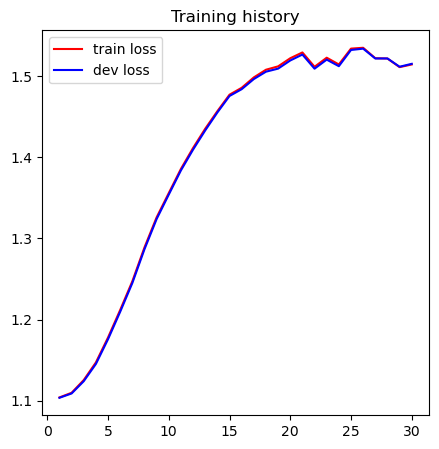

In [13]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()